# End-to-End XGBoost Workflow for Kickstarter Data

## Workflow

Many tutorials show how to build a model, yet few tutorials show the end-to-end workflow of modeling and statistical analysis of a novel dataset. The goal of this tutorial is to cover the entire end-to-end process.

For our data workflow, we start with a cleaning phase. During that phase, we intake the dataset, build our tools to clean it and split it, and prepare the data for an initial model. This is a rigorous step, and it is concluded when (1) we can run a preliminary working model and (2) we are prepared to start iterating. 

After that, we will set up our MLFlow environment to track our work, and then we will begin iterating. This could be iterations in our pipeline, engineering new features, and working in detail on improving the model. As a final step, we will package everything up for production and run final checks to ensure it can survive a production environemnt. 

Phase 1: Manual Cleaning + EDA + Prototyping

* We will do the initial cleaning on the data and prepare it for modeling. We generally do this "manually" but we will still build a base cleaning function and pipeline (it's easy, and more efficient).
* Start with eduplciation, row-wise filtering the data (out of scope data, invalid rows, etc.)
* Conduct preliminary EDA on full dataset: distributions, outliers, missingness, data quality. Get insights into what is needed to clean the data (and later, preprocess it).
* Split the data + build preliminary cleaning pipeline
* Perform rest of EDA on the training set with an eye toward preprocessing (categorical data encoding, imputation, scaling, and feature engineering)
* Feature engineering is biggest part--hypothesize causal drivers of the outcome, build features
* Update pipeline--ready to train first model
* Run simple baseline models (e.g., `LogisticRegression`, `RandomForest`, `XGBoost`) using default settings
* Evaluate basic performance using accuracy, AUC, or F1
* Check feature importance and rough signal strength
* Handle class imbalance roughly (e.g., `scale_pos_weight`)
* Have a sense for how to go forward

Phase 2: Save Working Prototype to MLflow

* Update pipeline for preprocessing to include the preliminary model
* Log the following to MLflow:
  * Model and pipeline artifacts (e.g., `.pkl`, `Pipeline` objects)
  * Key metrics (e.g., accuracy, AUC, F1 score)
  * Input data version or hash (e.g., via DVC, manual checksum, or metadata)
* Use this as your first reproducible and referenceable baseline

Phase 3: Iterate Model

* Ensure all pipeline steps (imputation, scaling, encoding) are modular and consistent
* Tune hyperparameters using grid/random search or Optuna
* Apply early stopping if supported (e.g., `XGBoost`, `LightGBM`)
* Calibrate predicted probabilities (e.g., with `CalibratedClassifierCV`)
* Use cross-validation to estimate performance
* Try alternate models or loss functions if warranted
* Log all experiments and parameters to MLflow for comparison

Phase 4: Finalize and Package

* Finalize:
  * Data schema and feature list
  * All preprocessing steps
  * Model choice and configuration
* Package the final pipeline and save to MLflow
* Ensure exact pipeline used at inference matches what was used at training
* Prepare for batch or real-time deployment (API-ready)
* Include model versioning and dependency tracking
* Plan for performance monitoring, drift detection, and retraining triggers


+---------------------+------------------------------------+--------------------------+---------------------------+
| Phase               | What To Do                         | Pipeline Usage           | MLflow Role               |
+---------------------+------------------------------------+--------------------------+---------------------------+
| EDA & Prototyping   | Clean data, explore distributions, | Cleaning / manual        | Not usually used          |
|                     | build quick baseline models        | preprocessing            |                           |
+---------------------+------------------------------------+--------------------------+---------------------------+
| Baseline Logging    | Log a promising prototype for      | MVP modeling pipeline or | Log model, metrics,       |
|                     | reproducibility                    | manual steps             | and artifacts             |
+---------------------+------------------------------------+--------------------------+---------------------------+
| Iterate & Improve   | Build full pipeline, tune          | Full pipeline.           | Log all runs +            |
|                     | hyperparams, validate on test data |                          | parameters via MLflow     |
+---------------------+------------------------------------+--------------------------+---------------------------+
| Finalize & Deploy   | Lock data schema, finalize model,  | Full pipeline + model    | Register final version    |
|                     | hand off for deployment            | wrapped                  | for production            |
+---------------------+------------------------------------+--------------------------+---------------------------+


## Preliminaries

In [34]:
import json
import os

import numpy as np

from kaggle.api.kaggle_api_extended import KaggleApi

import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pyarrow as pa

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

In [35]:
# get env variables
username = os.getenv("KAGGLE_USERNAME")
key = os.getenv("KAGGLE_KEY")

# connect to kaggle
api = KaggleApi()
api.authenticate()
api.dataset_download_files('kemical/kickstarter-projects', path='kickstarter_data', unzip=True)

# load data
df = pd.read_csv("kickstarter_data/ks-projects-201801.csv")

Dataset URL: https://www.kaggle.com/datasets/kemical/kickstarter-projects


In [36]:
# check data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


# Phase 1. Cleaning --> Initial Model

We will next clean the data. Our architecture will look as follows:

1. Pre-cleaning
2. Split data
3. EDA + Preprocessing Pipeline
4. Model


#### 1. **Preliminary cleaning function** 
Often, we create a function to do initial cleaning on the data prior to splitting the data into train/test sets. Specifically, at this step, we do anything that involves dropping rows or removing out-of-scope data (e.g., duplicate data, data we would not wish to use to train or infer upon, etc.).

We cannot do this *within* the pipeline, as that occurs after the data split (step 2), during which we will separate the **y** column (outcome) from the dataset of predictors (**X** matrix). From that point on, it is very difficult to remove rows of data, as removals must be coordinated across two separate objects. Better to simply do this up front.

During this step, we must look closely at the data—specifically at the distributions and contents of individual variables. However, we must be very careful not to explore or estimate anything that reflects relationships between features and the outcome. The reason is that we are about to split the data into a training set (in which we explore and model the data extensively) and a testing set (where we assess how the model performs on unseen data). Generally, models built on the training set will be calibrated to parameters and insights derived from the training set and will overperform on that data—they will perform worse on *new* (unseen) data.

At **this point**, we have not yet split the data. So, we can and should derive rules for row-wise deletion using the full dataset. But we **must not** estimate anything from the full data that would be used in modeling—no imputing, no computing means or medians, no encoding decisions based on outcome distributions, and certainly no exploration of `X --> y` relationships.

Generally, during this step, I like to do the following:

a. Row-wise deletion due to duplicates (pre-split)

b. Row-wise deletion due to excessive missingness (pre-split; define the rule here)

c. Row-wise deletion due to out-of-scope data (pre-split)


At this time, we might also write code that we can use later for:

d. Invalid data to repair (post-split, in-pipeline)

e. Unnecessary columns to drop (post-split, in-pipeline)

f. Variable types (e.g., string --> datetime) (post-split, in-pipeline)


Steps a–c must be performed before separating the **y** column, when row-wise deletion is still possible. Steps d–f should be part of a transformer inside a pipeline after the split, as they don’t require removing rows.

Lastly, we should *begin to think about* preprocessing steps, which generally involve:

g. Imputation methods (e.g., mean? median? KNN?)

h. Scaling (e.g., z-score? min-max?)

i. Encoding of categorical variables (e.g., one-hot vs. reduced categories)

j. Feature engineering (e.g., time deltas, log transforms, interaction terms)

Steps g–j should **NOT** occur at this point, but it’s helpful to start thinking ahead. We’ll revisit them after the split.

Finally, be thinking at this point about **leakage**: Any column that contains information only knowable after the outcome occurs is leakage. These should be removed entirely, as they would not be available at inference time. Common culprits include timestamps, summary statistics, or status flags recorded after the fact. This is data that would not exist at the time of prediction in the real world--and we only know it **now** in this data becuase it's retrospective. We will remove it as part of step e in our pipeline, but be thinking hard about anything that "gives away" the outcome variable (y).

#### 2. **Split the data** 

Split the data into an **X** matrix and **y** vector. Then split them into train and test sets. If there’s any cleaning to do on **y** (e.g., convert strings to binary 0/1 for classification), do it here.

Now is also a good time to build a preliminary pipeline:

* A raw data cleaning function for steps a–c above (row-wise removal)
* A custom transformer inside a pipeline for steps d–f (value-level cleaning)
* A placeholder for later pipeline steps (g–j) for preprocessing

You can now aim this preliminary pipeline at the training (and test) data. From there, you can explore the training data to make decisions about preprocessing.


#### 3. **EDA and preprocessing planning.** 
This is where you perform detailed EDA to decide on g–j. What preprocessing steps will you use? Imputation strategy? Scaling? Encoding? What new features do you want to engineer?

It’s also common at this stage to realize that additional data cleaning is needed—perhaps invalid values, redundant columns, or unusable text fields were missed earlier. If so, return to your raw cleaning function and revise it accordingly before proceeding. It's normal for cleaning and EDA to iterate a bit before things stabilize. 

Update the pipeline accordingly. When this step is complete, your data should be ready to pass into a model.


#### 4. Preliminary model
You should now be able to fit a preliminary model easily.


Let's get started!

## 1.1 - Preliminary Cleaning Functions

* Duplicates, Out of Scope, Missing (pre-split row removal)
* Column Types, Column Drops, Invalid Data (post-split)

Will produce:
* pre-cleaning function
* cleaning transformer
* possible feature-engineering transformer


Duplicate rows first

In [37]:
# check prior to doing anything
df.duplicated().sum()

np.int64(0)

For id:

In [38]:
df.duplicated(subset=['ID']).sum()

np.int64(0)

For title -- nearly 3k duplicates!

In [39]:
df.duplicated(subset=['name']).sum()

np.int64(2896)

Examine them:

In [40]:
name_dups = (
    df['name']
    .loc[
        df.duplicated(subset=['name'])
        ]
    .value_counts()
)

print(name_dups)

name
New EP/Music Development                                   40
Canceled (Canceled)                                        12
Music Video                                                10
N/A (Canceled)                                             10
Cancelled (Canceled)                                        9
                                                           ..
GreyX - Study Faster, Smarter, and More Effectively NOW     1
Project IRIS                                                1
The Unknowns                                                1
On The Rocks                                                1
Guilt                                                       1
Name: count, Length: 2228, dtype: int64


In [41]:
#top 40
name_dups[:40]

name
New EP/Music Development                         40
Canceled (Canceled)                              12
Music Video                                      10
N/A (Canceled)                                   10
Cancelled (Canceled)                              9
Debut Album                                       9
New EP / Music Development                        9
The Journey                                       8
Reflections                                       8
Pizza                                             7
The Awakening                                     7
The Other Side                                    7
A Midsummer Night's Dream                         7
Pasta Salad                                       6
Choices                                           6
Broken                                            5
Project (Canceled)                                5
Alone                                             5
Home                                              5
Chocola

It appears that a lot of projects have "Canceled" in the name. Can we have a rule that we drop all of them? First, inspect them. 

Some filtering logic:

* `df[condition]` is a great tool for returning rows that meet a boolean condition, but it's limited to that and always produces a *copy* (i.e., modifying it does NOT modify in place). If we want to select and filter as we do in R, we need `.loc` and `.iloc`. When you see those, you're indexing. 

* `.loc[]` is our tool for filtering based on the NAMES (index labels) of rows and columns. 
    * It's similar to R's `data[row, column]` api but for *labels*, not positions.
    * It will search for effectively "row names" and "column names" (the index labels)
    * By default, if we enter one value, it's rows. 
    * Because it only looks at index labels (names), `.loc[3]` looks for a row with an index lavel value of 3, not the 3rd position. Often those are the same, but don't trust that. 
    * If you want to search by VALUES, you can enter a boolean series called a "mask" (`data.loc[data['score'] == 90]`) or you can pre-create them  such as `mask = data['score'] == 90` and then using `mask` as your condition in `data.loc[mask]`. Importantly, what it's doing under the hood is boolean mask values --> grab indices that correspond to True in the mask --> grab rows. That's because this works with indices. 
    * E.g., you want to find all rows with a `score` value of 90 and return `id` and `name` columns: `data.loc[data['score'] == 90, ['id', 'name']]`

* `.iloc[]` is our tool for filtering based on the POSITION of a cell. It's the same idea, but you enter row positions. So, `.iloc[4, 6]` returns row 4, column 6. You can pass it lists of integers but NOT a boolean series. This is very similar to R, and you can also include lists as you might in R (e.g., `.iloc[:,:])` for all rows, all columns).

* `.loc` and `.iloc` normally return views if you do `df.loc[]` or `df.iloc[]` ... but if you are running `.loc[]` or `.iloc[]` at the end of a chain or subsetted df, you may be pulling a copy (e.g., `df['var1'].iloc[]`) That is because those subsetted or chained dfs typically produce copies. 

In [42]:
# inspect with 'canceled' in the name
# use na = False to make sure missing values are flagged as false (vs. NaN), so we can safely use this for filtering
(
    df["name"]
    .loc[
        df["name"].str.contains("Canceled", case = False, na = False)
    ]
    .unique()
)

array(['STUDIO IN THE SKY - A Documentary Feature Film (Canceled)',
       'Raise the Woof, expanding the love (Canceled)',
       'Glyscian Debut Album Recording (Canceled)', ...,
       'Cards and Chit Network Season 2! (Canceled)',
       "Angela's Poetry (Canceled)",
       'ChknTruk Nationwide Charity Drive 2014 (Canceled)'],
      shape=(22980,), dtype=object)

Decision
* drop duplicates overall
* drop duplicates on ID

* drop out of scope: contains "canceled"

In [43]:
def pre_cleaning(df):
    df = df.copy()
    
    # 1. Duplicate handling
    df.drop_duplicates(inplace=True)
    df.drop_duplicates(subset=["ID"], inplace=True)

    # 2. Out of scope
    df = (
        df
        .loc[
            ~df["name"].str.contains("Canceled", case=False, na=False)
        ]
    )

    return df

What about duplicate names? Are they out of scope?

In [44]:
(
    df['name']
    .loc[
        df.duplicated(subset='name')
        ]
    .value_counts()
)

name
New EP/Music Development                                   40
Canceled (Canceled)                                        12
Music Video                                                10
N/A (Canceled)                                             10
Cancelled (Canceled)                                        9
                                                           ..
GreyX - Study Faster, Smarter, and More Effectively NOW     1
Project IRIS                                                1
The Unknowns                                                1
On The Rocks                                                1
Guilt                                                       1
Name: count, Length: 2228, dtype: int64

They are not out of scope, but we can create a feature to represent that later. That's a bit ahead of us, but let's go ahead and start building a custom transformer now

First, let's build the base structure:

In [45]:
class FeatureEng(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X=X.copy()
        return X

Now let's populate it

In [46]:
class FeatureEng(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X=X.copy()
        
        #flag duplicate names
        X["is_dup_name"] = (
            X["name"]
            .duplicated(keep=False) #must set to false to flag all duplicates
        )
        return X

When we go to create features later, we can use this to flag those that had a duplicated name!

Regarding out of scope, I think we only want projects that are successful or failed

In [47]:
df["state"].value_counts()

state
failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: count, dtype: int64

In [ ]:
def pre_cleaning(df):
    df = df.copy()
    
    # 1. Duplicate handling
    df.drop_duplicates(inplace=True)
    df.drop_duplicates(subset=["ID"], keep = "first", inplace=True)

    # 2. Out of scope
    df = (
        df
        .loc[
            ~df["name"].str.contains("Canceled", case=False, na=False)
        ]
    )

    # only look at clearly successful or failed projects
    df = (
        df
        .loc[
            df["state"].isin(["successful", "failed"])
        ]
    )

    return df

What about missingness?

In [49]:
# boolan grid of missingness
df.isna()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
378657,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
378658,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
378659,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [50]:
#(
#    df
#    .isna()
#    # apply to columns
#    .apply(
#        sum, axis=0
#    )
#)

df.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

Inspect missing on name -- goign to want to filter those out also (missing on ID also)

In [51]:
(
    df
    .loc[
        df["name"].isna()
    ]
)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.0,2012-01-01 12:35:31,100.0,failed,1,US,100.00,100.00,200000.00
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.0,2012-12-19 23:57:48,196.0,failed,12,GB,317.73,316.05,3224.97
309991,648853978,NaN,Product Design,Design,USD,2016-07-18,2500.0,2016-06-18 05:01:47,0.0,suspended,0,US,0.00,0.00,2500.00
338931,796533179,NaN,Painting,Art,USD,2011-12-05,35000.0,2011-11-06 23:55:55,220.0,failed,5,US,220.00,220.00,35000.00


In [ ]:
def pre_cleaning(df):
    df = df.copy()
    
    # 1. Duplicate handling
    df.drop_duplicates(inplace=True)
    df.drop_duplicates(subset=["ID"], keep = "first", inplace=True)

    # 2. Out of scope
    df = (
        df
        .loc[
            ~df["name"].str.contains("Canceled", case=False, na=False)
        ]
    )

    # only look at clearly successful or failed projects
    df = (
        df
        .loc[
            df["state"].isin(["successful", "failed"])
        ]
    )

    # 3. Missing on key vars
    df.dropna(subset=["name", "ID"], inplace=True)

    return df

Try it out

In [53]:
pre_cleaning(df).head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


Looks like we're done with the pre-cleaning stuff (pre-split stuff), but other cleaning steps happen post split:
* column drops (redundant, leakage, etc.)
* invalid data
* type conversions

Looking at that, we have some clearly redundant or leakage columns:
* goal is not needed -- want usd_goal_real
* pledged and usg_pledged_real are going to be leakage (if we know that, might as well know the success)
* backers is leakage -- more backers shows progress and is not something we could predict early on

Those will go in a cleaning transformer for our pipeline (not row drops). Let's try that now.

In [54]:
#template
class Cleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        return X

In [55]:
class Cleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.drop_columns = ["goal", "usd_pledged_real", "pledged"]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X.drop(columns = self.drop_columns, inplace=True)
        return X

Ok! What about type conversions?

In [56]:
pre_cleaning(df).info()

<class 'pandas.core.frame.DataFrame'>
Index: 331666 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                331666 non-null  int64  
 1   name              331666 non-null  object 
 2   category          331666 non-null  object 
 3   main_category     331666 non-null  object 
 4   currency          331666 non-null  object 
 5   deadline          331666 non-null  object 
 6   goal              331666 non-null  float64
 7   launched          331666 non-null  object 
 8   pledged           331666 non-null  float64
 9   state             331666 non-null  object 
 10  backers           331666 non-null  int64  
 11  country           331666 non-null  object 
 12  usd pledged       331456 non-null  float64
 13  usd_pledged_real  331666 non-null  float64
 14  usd_goal_real     331666 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 40.5+ MB


In [57]:
df['deadline']

0         2015-10-09
1         2017-11-01
2         2013-02-26
3         2012-04-16
4         2015-08-29
             ...    
378656    2014-10-17
378657    2011-07-19
378658    2010-08-16
378659    2016-02-13
378660    2011-08-16
Name: deadline, Length: 378661, dtype: object

In [58]:
df['launched']

0         2015-08-11 12:12:28
1         2017-09-02 04:43:57
2         2013-01-12 00:20:50
3         2012-03-17 03:24:11
4         2015-07-04 08:35:03
                 ...         
378656    2014-09-17 02:35:30
378657    2011-06-22 03:35:14
378658    2010-07-01 19:40:30
378659    2016-01-13 18:13:53
378660    2011-07-19 09:07:47
Name: launched, Length: 378661, dtype: object

Those should be datetime. Everything else is fine

In [59]:
class Cleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.drop_columns = ["goal", "usd_pledged_real", "pledged", "backers"]
        self.date_columns = ["launched", "deadline"]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        # 4. Drop columns
        X.drop(columns = self.drop_columns, inplace=True)

        # 5. type conversions
        for col_ in self.date_columns:
            X[col_] = pd.to_datetime(X[col_], errors = "coerce")

        return X

Lastly, our sixth and final item is invalid data. We can get more at this in a bit, but for now:
* our goal should be a positive value
* dates shoudl happen in order

If that fails, we should make that value np.nan

In [60]:
class Cleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.drop_columns = ["goal", "usd_pledged_real", "pledged", "backers"]
        self.date_columns = ["launched", "deadline"]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        # 4. Drop columns
        X.drop(columns = self.drop_columns, inplace=True)

        # 5. type conversions
        for col_ in self.date_columns:
            X[col_] = pd.to_datetime(X[col_], errors = "coerce")

        # 6. invalid data
        # index rows with mask, columns with list of names --- assign to the pandas "not a time" type
        invalid_dates = X["deadline"] < X["launched"]
        X.loc[invalid_dates, ["deadline", "launched"]] = pd.NaT

        X["usd_goal_real"] = (
            X["usd_goal_real"]
            .mask(
                X["usd_goal_real"] < 0 #default behavior is to replace true values with np.nan
            )
        )

        return X

## 1.2. Univariate EDA + Remaining Cleaning + Preprocessing Planning

Next we will examine our clean data for anything that might drive row-wise deletion that we missed. We will often look separately at the numeric vs. categorical columns here. 

We will therefore have to go looking at the distributions of data in each variable. While we're here, we should also begin **planning** (but not executing) on these steps:

Cleaning:
* Invalid data to repair (post-split, in-pipeline)
* Unnecessary columns to drop (post-split, in-pipeline)
* Especially leakage columns!! Drop them
* Variable types (e.g., string --> datetime) (post-split, in-pipeline)

Preprocessing:
* Imputation
* Scaling
* Encoding
* Feature engineering

Generally, I write code regaridng the first three (cleaning) now, and then I move it to the pipeline in the next step. I also am taking notes regarding preprocessing at this point, but remember we don't go further than that. 

We want to leave this step with:
* Code for raw data cleaning 
* Thoughts for **preprocessing**:
    * Imputation
    * Transformation
    * Encoding
    * Feature engineering


In [61]:
pre_cleaning(df).info()

<class 'pandas.core.frame.DataFrame'>
Index: 331666 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                331666 non-null  int64  
 1   name              331666 non-null  object 
 2   category          331666 non-null  object 
 3   main_category     331666 non-null  object 
 4   currency          331666 non-null  object 
 5   deadline          331666 non-null  object 
 6   goal              331666 non-null  float64
 7   launched          331666 non-null  object 
 8   pledged           331666 non-null  float64
 9   state             331666 non-null  object 
 10  backers           331666 non-null  int64  
 11  country           331666 non-null  object 
 12  usd pledged       331456 non-null  float64
 13  usd_pledged_real  331666 non-null  float64
 14  usd_goal_real     331666 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 40.5+ MB


Let's take a look at the data again. do we want to drop anything?

In [62]:
pre_cleaning(df).head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


After drops we have already identified

Remaining categorical variables are:
* main_category
* category
* currency
* country
* state (target)

Text data we might use nlp on to suss signal
* name
* category

In [63]:
numeric_cols = ["usd_goal_real"]
cat_cols = ["main_category", "category", "currency", "country", "state"]

View the numeric cols in univariate:

Wrote this before when i had several numeric columns. nice to see the example however

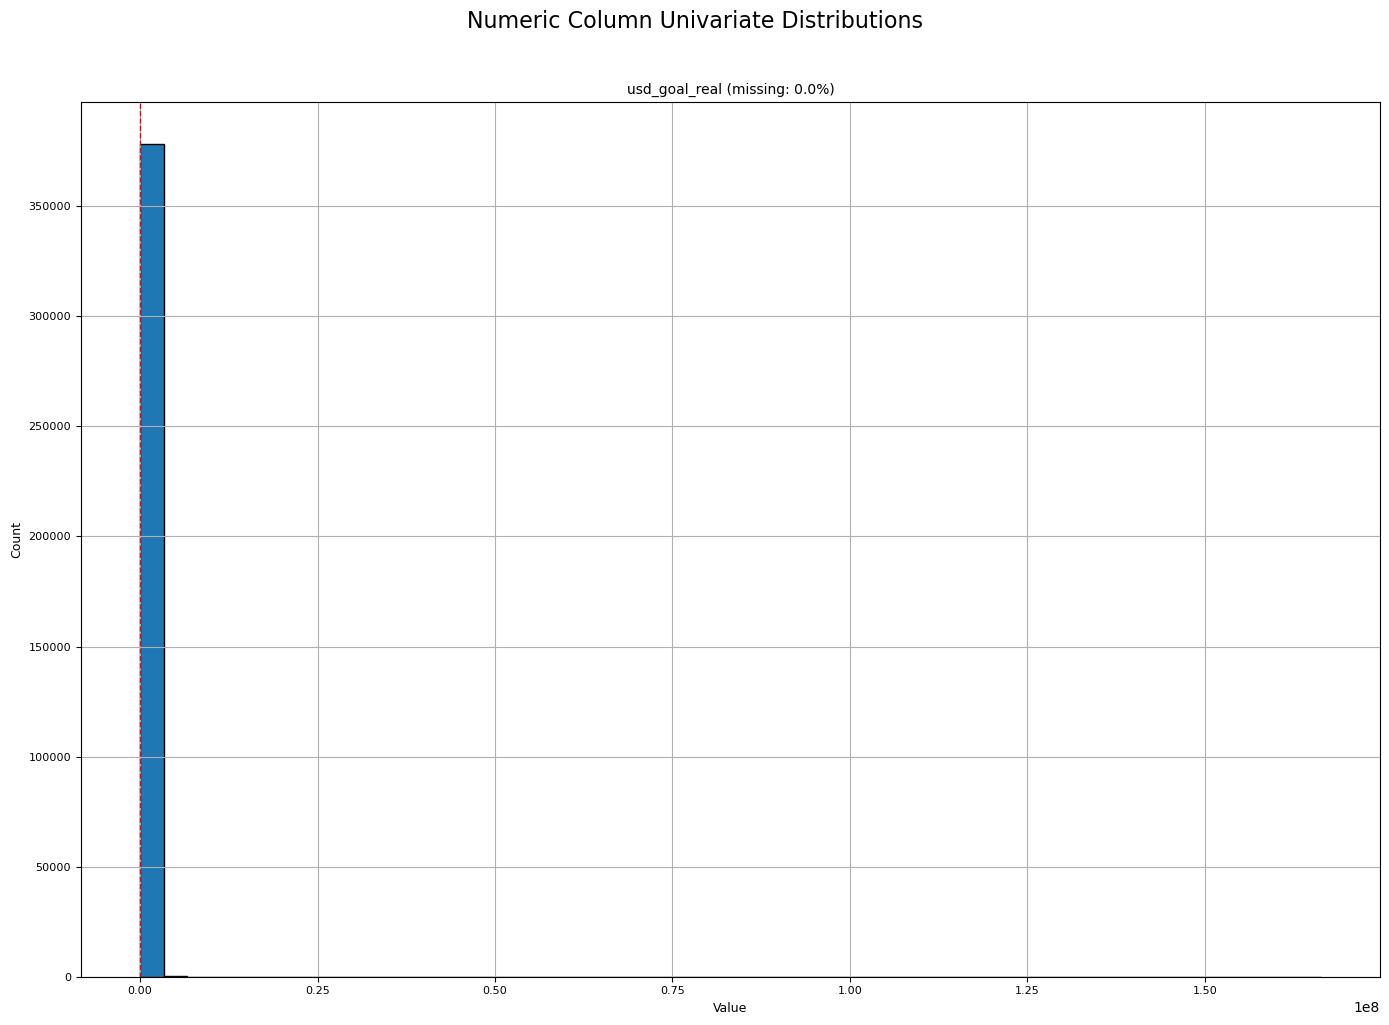

In [64]:
axes = df[numeric_cols].hist(bins=50, figsize=(14, 10), edgecolor="black")

plt.suptitle("Numeric Column Univariate Distributions", fontsize=16, y=1.02)

for col, ax in zip(numeric_cols, axes.flatten()):
    ax.grid(True)
    ax.set_xlabel("Value", fontsize=9)
    ax.set_ylabel("Count", fontsize=9)
    
    # Show missing % in title
    missing_pct = df[col].isna().mean() * 100
    ax.set_title(f"{col} (missing: {missing_pct:.1f}%)", fontsize=10)

    # Add median line
    if df[col].notna().sum() > 0:
        median = df[col].median()
        ax.axvline(median, color="red", linestyle="--", linewidth=1)

    ax.tick_params(axis="both", labelsize=8)

plt.tight_layout()
plt.show()

Notes: 
* Extreme right skew
* Most values close to zero

Implications: 
* log1p transform may be better fit for our work
* will want to median impute

Impossible data:
* can't be negative (update cleaning function) -- already implemented

In [ ]:
class FeatureEng(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X=X.copy()
        
        #flag duplicate names
        X["is_dup_name"] = (
            X["name"]
            .duplicated(keep=False) #must set to false to flag all duplicates
        )

        #transform goal to a log version
        # will need to come back and drop original at some point
        X["log_usd_goal_real"] = np.log1p(X["usd_goal_real"])
        return X

Next let's look at the categorical cols.

In [66]:
for col in cat_cols:
    print(f"EXAMINING VARIABLE {col}")
    print(pre_cleaning(df)[col].value_counts())
    print("__________")

EXAMINING VARIABLE main_category
main_category
Film & Video    56525
Music           45949
Publishing      35442
Games           28520
Technology      27050
Art             25638
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: count, dtype: int64
__________
EXAMINING VARIABLE category
category
Product Design     18680
Documentary        14522
Music              12633
Tabletop Games     11744
Shorts             11394
                   ...  
Residencies           68
Letterpress           46
Chiptune              33
Literary Spaces       19
Taxidermy             10
Name: count, Length: 159, dtype: int64
__________
EXAMINING VARIABLE currency
currency
USD    261504
GBP     29475
EUR     14377
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY  

Notes:
* We have one country value that is effectively a corrupt value and refers to a missing entry. There's no reason we can't leave it as is, but in the future, it might be good to call it 'missing' instead.

* some category variables are high cardinality
    * consider 'other' category + top 10-20 for these

Now examine date cols:

<Axes: >

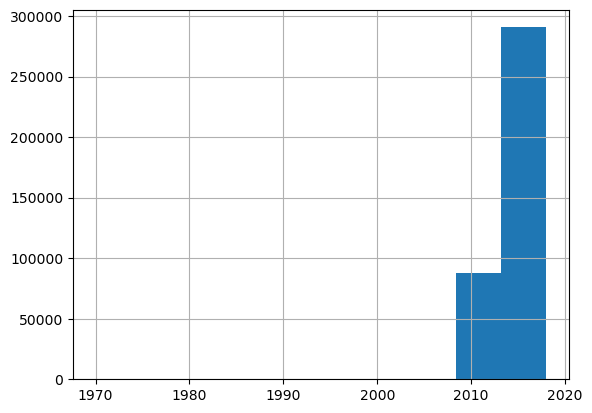

In [67]:
pd.to_datetime(df['launched']).hist()

<Axes: >

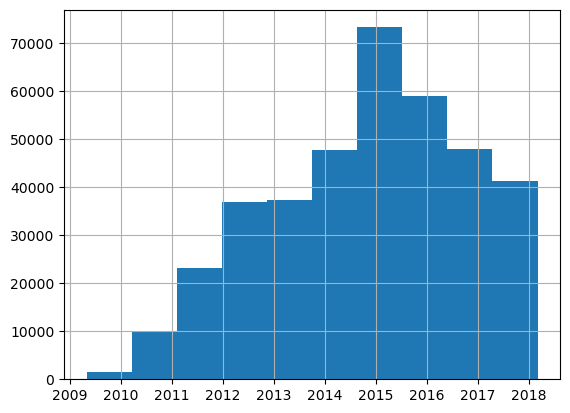

In [68]:
pd.to_datetime(df['deadline']).hist()

Notes:

* Cleaning: duration can't be negative (already done)
* pre-cleaning: just drop rows with missing dates...imputing seems tricky and possibly not valid
* feature engineering -- grab duration, date of week, month, etc.

In [ ]:
def pre_cleaning(df):
    df = df.copy()
    
    # 1. Duplicate handling
    df.drop_duplicates(inplace=True)
    df.drop_duplicates(subset=["ID"], keep = "first", inplace=True)

    # 2. Out of scope
    df = (
        df
        .loc[
            ~df["name"].str.contains("Canceled", case=False, na=False)
        ]
    )

    # only look at clearly successful or failed projects
    df = (
        df
        .loc[
            df["state"].isin(["successful", "failed"])
        ]
    )

    # 3. Missing on key vars
    df.dropna(subset=["name", "ID", "launched", "deadline"], inplace=True)

    return df

In [ ]:
class FeatureEng(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X=X.copy()
        
        #flag duplicate names
        X["is_dup_name"] = (
            X["name"]
            .duplicated(keep=False) #must set to false to flag all duplicates
        )

        #transform goal to a log version
        X["usd_goal_real"] = np.log1p(X["usd_goal_real"])

        # Duration in days (NaT-safe subtraction)
        X["duration"] = (X["deadline"] - X["launched"]).dt.days

        # Day of week (0 = Monday, 6 = Sunday)
        X["launched_dow"] = X["launched"].dt.dayofweek
        X["deadline_dow"] = X["deadline"].dt.dayofweek

        # Weekend flags - make 0/1
        X["launched_is_weekend"] = X["launched_dow"].isin([5, 6]).astype(int)
        X["deadline_is_weekend"] = X["deadline_dow"].isin([5, 6]).astype(int)

        return X

## 2. Split Data + Preliminary Pipeline

Next, we will repackage that into a pipeline so we have the base architecture to work with.
1. Cleaning function runs before pipeline, does any row dropping. So .. half of our cleaning function
2. Split data
3. Clean y
4. Rest of cleaning comes as part of pipeline So... other half of our cleaning function

This will do a couple good things for us. First, it ensures the data is split so we can do EDA. Second, it ensures that the split and cleaning steps happen in such a way that we can USE this later and not have to re-split or re-do everything. 

In [118]:
def pre_cleaning(df):
    df = df.copy()
    
    # 1. Duplicate handling
    df.drop_duplicates(inplace=True)
    df.drop_duplicates(subset=["ID"], keep = "first", inplace=True)

    # 2. Out of scope
    df = (
        df
        .loc[
            ~df["name"].str.contains("Canceled", case=False, na=False)
        ]
    )

    # only look at clearly successful or failed projects
    df = (
        df
        .loc[
            df["state"].isin(["successful", "failed"])
        ]
    )

    # 3. Missing on key vars
    df.dropna(subset=["name", "ID", "launched", "deadline"], inplace=True)

    return df

# Clean data
df_clean = pre_cleaning(df)

# Split data
X = df_clean.drop(columns=["state"])
y = df_clean["state"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.20, random_state=42)

# Clean y variable to be numeric
def clean_y(input: pd.Series) -> pd.Series:
    """Converts y variable values to binary 1/0 for prediction"""
    return (
        input
        .replace({"failed": 0, "successful": 1})
        .astype("int")
    )
y_train = clean_y(y_train)
y_test = clean_y(y_test)

# Custom Pipeline Classes for Rest of Cleaning
class Cleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.drop_columns = ["goal", "usd_pledged_real", "pledged", "backers", "usd pledged"]
        self.date_columns = ["launched", "deadline"]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        # 4. Drop columns
        X.drop(columns = self.drop_columns, inplace=True)

        # 5. type conversions
        for col_ in self.date_columns:
            X[col_] = pd.to_datetime(X[col_], errors = "coerce")

        # 6. invalid data
        # index rows with mask, columns with list of names --- assign to the pandas "not a time" type
        invalid_dates = X["deadline"] < X["launched"]
        X.loc[invalid_dates, ["deadline", "launched"]] = pd.NaT

        X["usd_goal_real"] = (
            X["usd_goal_real"]
            .mask(
                X["usd_goal_real"] < 0 #default behavior is to replace true values with np.nan
            )
        )

        return X
    
class FeatureEng(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X=X.copy()
        
        #flag duplicate names
        X["is_dup_name"] = (
            X["name"]
            .duplicated(keep=False) #must set to false to flag all duplicates
        )

        #transform goal to a log version
        X["usd_goal_real"] = np.log1p(X["usd_goal_real"])

        # Duration in days (NaT-safe subtraction)
        X["duration"] = (X["deadline"] - X["launched"]).dt.days

        # Day of week (0 = Monday, 6 = Sunday)
        X["launched_dow"] = X["launched"].dt.dayofweek
        X["deadline_dow"] = X["deadline"].dt.dayofweek

        # Weekend flags - make 0/1
        X["launched_is_weekend"] = X["launched_dow"].isin([5, 6]).astype(int)
        X["deadline_is_weekend"] = X["deadline_dow"].isin([5, 6]).astype(int)

        return X

    
# Make Pipeline -- No Model Yet
pipeline = Pipeline(steps = [
    ("clean", Cleaning()),
    ("fe", FeatureEng()),
    ("preproc", ColumnTransformer(
        transformers=[
            ("imp", SimpleImputer(strategy = "median"), [
                "usd_goal_real", "is_dup_name" #not imputing day stuff as dropping rows with missing dates
                ])
            #("scal", StandardScaler(), numeric_features), 
            #("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
        ],
        remainder="passthrough" #ensures that other columns aren't dropped
    ))

])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# those will be arrays--make a df version
# go to last named step
preproc = pipeline.named_steps["preproc"]
feature_names = preproc.get_feature_names_out()
feature_names = [name.replace("remainder__", "") for name in feature_names]
feature_names = [name.replace("imp__", "") for name in feature_names]
X_explore = pd.DataFrame(X_train, columns=feature_names)

#add y_train back in, but pass to numpy first to avoid index alignment
X_explore = pd.concat([
    X_explore, 
    pd.Series(y_train.to_numpy(), name="state")
    ], axis=1)

for col_ in ["usd_goal_real", "duration"]:
    X_explore[col_] = X_explore[col_].astype(float)

for col_ in ["launched_dow", "deadline_dow", "is_dup_name", "launched_is_weekend", "deadline_is_weekend"]:
    X_explore[col_] = X_explore[col_].astype(int)

/var/folders/bj/45wmvwcj3njb1xt57ps1k86r0000gn/T/ipykernel_8540/3575747646.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"failed": 0, "successful": 1})
/var/folders/bj/45wmvwcj3njb1xt57ps1k86r0000gn/T/ipykernel_8540/3575747646.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"failed": 0, "successful": 1})


Confirm X_explore has correct columns -- but type converseion needed

In [119]:
X_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265332 entries, 0 to 265331
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   usd_goal_real        265332 non-null  float64       
 1   is_dup_name          265332 non-null  int64         
 2   ID                   265332 non-null  object        
 3   name                 265332 non-null  object        
 4   category             265332 non-null  object        
 5   main_category        265332 non-null  object        
 6   currency             265332 non-null  object        
 7   deadline             265332 non-null  datetime64[ns]
 8   launched             265332 non-null  datetime64[ns]
 9   country              265332 non-null  object        
 10  duration             265332 non-null  float64       
 11  launched_dow         265332 non-null  int64         
 12  deadline_dow         265332 non-null  int64         
 13  launched_is_we

In [120]:
X_explore.columns

Index(['usd_goal_real', 'is_dup_name', 'ID', 'name', 'category',
       'main_category', 'currency', 'deadline', 'launched', 'country',
       'duration', 'launched_dow', 'deadline_dow', 'launched_is_weekend',
       'deadline_is_weekend', 'state'],
      dtype='object')

## 3. Multivariable EDA + Transformers


Let's explore what we can do with X_explore

In [101]:
(
    X_explore[['state', 'usd_goal_real']]
    .corr()
    )

,state,usd_goal_real
state,1.000000,-0.223711
usd_goal_real,-0.223711,1.000000


Is that sig?

In [102]:
from scipy.stats import pointbiserialr

print(
    pointbiserialr(X_explore["state"], X_explore["usd_goal_real"])
)

SignificanceResult(statistic=np.float64(-0.2237111420719242), pvalue=np.float64(0.0))


Ever so slight pattern--if you have a larger goal, you are SLIGHTLY less likely to win

Does that vary by main category?

In [103]:
import statsmodels.api as sm
means = (
    X_explore
    .groupby("main_category")
    # "For each group of rows with the same main_category, apply this function to the sub-DataFrame g and return the result."
    .apply(lambda g: sm.stats.DescrStatsW(g["state"]).tconfint_mean())
    .apply(pd.Series)
)

means.columns = ["lower", "upper"]
means["mean"] = X_explore.groupby("main_category")["state"].mean()

means

/var/folders/bj/45wmvwcj3njb1xt57ps1k86r0000gn/T/ipykernel_8540/954882736.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: sm.stats.DescrStatsW(g["state"]).tconfint_mean())


,lower,upper,mean
main_category,,,
Art,0.441627,0.455269,0.448448
Comics,0.581490,0.603126,0.592308
Crafts,0.260377,0.282407,0.271392
Dance,0.641584,0.676359,0.658972
Design,0.407462,0.421022,0.414242
Fashion,0.276653,0.290686,0.283670
Film & Video,0.411997,0.421079,0.416538
Food,0.269132,0.282319,0.275725
Games,0.433533,0.446411,0.439972


Lots of variability across main categories!!

That's a wald interval (using mean / t for proportions)

Try a true correct CI

In [104]:
from statsmodels.stats.proportion import proportion_confint

# Count successes and total in each group
counts = X_explore.groupby("main_category")["state"].sum()
n = X_explore.groupby("main_category")["state"].count()

# Wilson CI (recommended)
lower, upper = proportion_confint(counts, n, alpha=0.05, method="wilson")

# Combine into DataFrame
means = pd.DataFrame({
    "prop": counts / n,
    "lower": lower,
    "upper": upper,
    "n": n
})

means


,prop,lower,upper,n
main_category,,,,
Art,0.448448,0.441638,0.455277,20426
Comics,0.592308,0.581450,0.603076,7930
Crafts,0.271392,0.260523,0.282542,6264
Dance,0.658972,0.641392,0.676125,2859
Design,0.414242,0.407479,0.421038,20278
Fashion,0.283670,0.276707,0.290737,15860
Film & Video,0.416538,0.412004,0.421086,45278
Food,0.275725,0.269182,0.282367,17648
Games,0.439972,0.433544,0.446420,22831


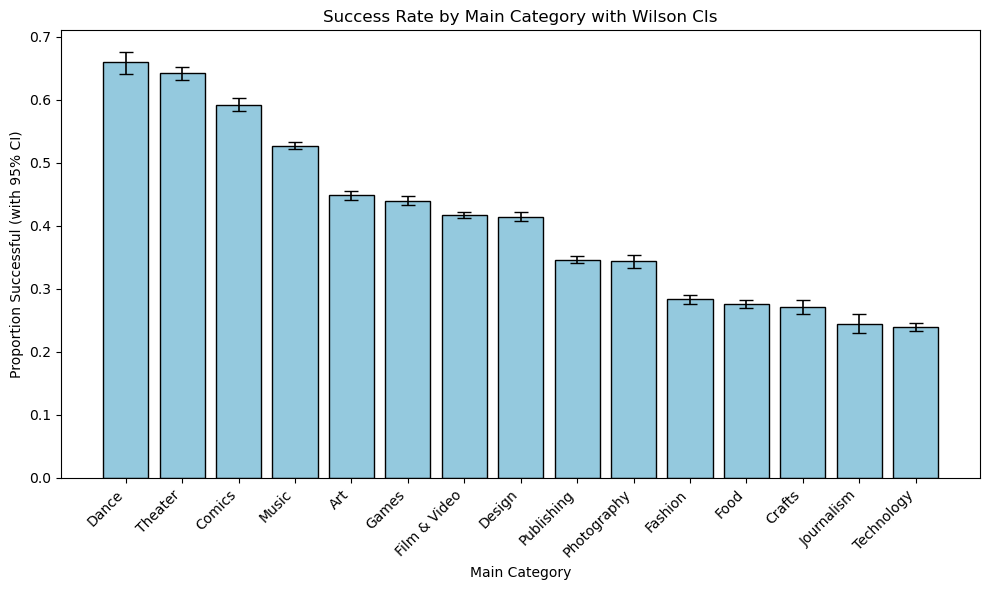

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Sort the DataFrame by proportion descending
means_sorted = means.sort_values("prop", ascending=False).reset_index()

# Step 2: Plot
plt.figure(figsize=(10, 6))

sns.barplot(
    data=means_sorted,
    x="main_category",
    y="prop",
    color="skyblue",
    edgecolor="black"
)

# Step 3: Add error bars (CIs)
plt.errorbar(
    x=range(len(means_sorted)),
    y=means_sorted["prop"],
    yerr=[
        means_sorted["prop"] - means_sorted["lower"],
        means_sorted["upper"] - means_sorted["prop"]
    ],
    fmt="none",
    c="black",
    capsize=5,
    linewidth=1.2
)

# Step 4: Style
plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion Successful (with 95% CI)")
plt.xlabel("Main Category")
plt.title("Success Rate by Main Category with Wilson CIs")
plt.tight_layout()
plt.show()


In [106]:
X_explore["usd_goal_real"]

0          8.516993
1          9.923331
2          8.987322
3          6.689002
4         10.819798
            ...    
265327     9.685137
265328    10.463132
265329    10.072321
265330    10.819798
265331     8.294300
Name: usd_goal_real, Length: 265332, dtype: float64

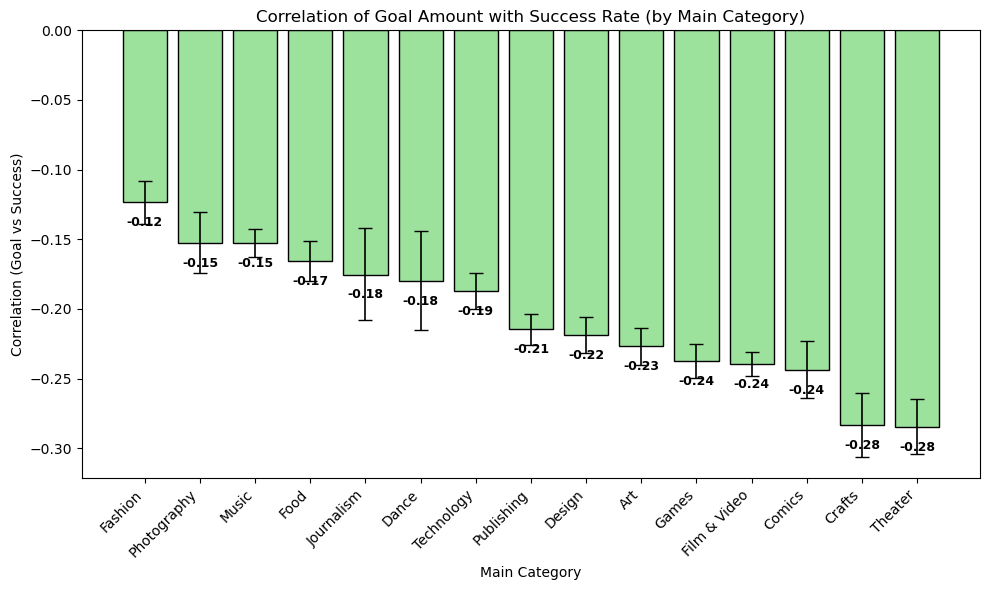

In [107]:
from scipy.stats import pointbiserialr, norm
import numpy as np

# Make a fisher correlation CI function
def correlation_ci(x, y, alpha=0.05):
    x = np.asarray(x)
    y = np.asarray(y)
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    n = len(x)

    r, p = pointbiserialr(x, y)
    if np.abs(r) == 1 or n < 4:
        # Perfect correlation or too small for CI
        return r, np.nan, np.nan, p, n

    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha / 2)
    z_low = z - z_crit * se
    z_high = z + z_crit * se
    ci_low, ci_high = np.tanh([z_low, z_high])

    return r, ci_low, ci_high, p, n

# apply to each group
results = []

for category, group in X_explore.groupby("main_category"):
    r, ci_low, ci_high, p, n = correlation_ci(group["usd_goal_real"], group["state"])
    results.append({
        "main_category": category,
        "correlation": r,
        "lower": ci_low,
        "upper": ci_high,
        "p_value": p,
        "n": n
    })

corr_df = pd.DataFrame(results).sort_values("correlation", ascending=False)


# plot it
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Bar plot
ax = sns.barplot(
    data=corr_df,
    x="main_category",
    y="correlation",
    color="lightgreen",
    edgecolor="black"
)

# Error bars
plt.errorbar(
    x=range(len(corr_df)),
    y=corr_df["correlation"],
    yerr=[
        corr_df["correlation"] - corr_df["lower"],
        corr_df["upper"] - corr_df["correlation"]
    ],
    fmt="none",
    c="black",
    capsize=5,
    linewidth=1.2
)

# Annotate each bar
for i, row in corr_df.reset_index().iterrows():
    y = row["correlation"]
    label = f"{y:.2f}"
    va = "bottom" if y >= 0 else "top"
    offset = 0.01 if y >= 0 else -0.01
    ax.text(i, y + offset, label, ha="center", va=va, fontsize=9, fontweight="bold")

# Formatting
plt.xticks(rotation=45, ha="right")
plt.ylabel("Correlation (Goal vs Success)")
plt.xlabel("Main Category")
plt.title("Correlation of Goal Amount with Success Rate (by Main Category)")
plt.tight_layout()
plt.show()




We see that different categories have a different association with goal size. Aspirational dance projects are less likely to get funded, whereas aspirational fashion projects less so. That doesn't consider the absolute number, however. A good logistic regression could unpack that (causal modeling). We will skip for now. In general, the combination of `category * goal` appears to have useful information

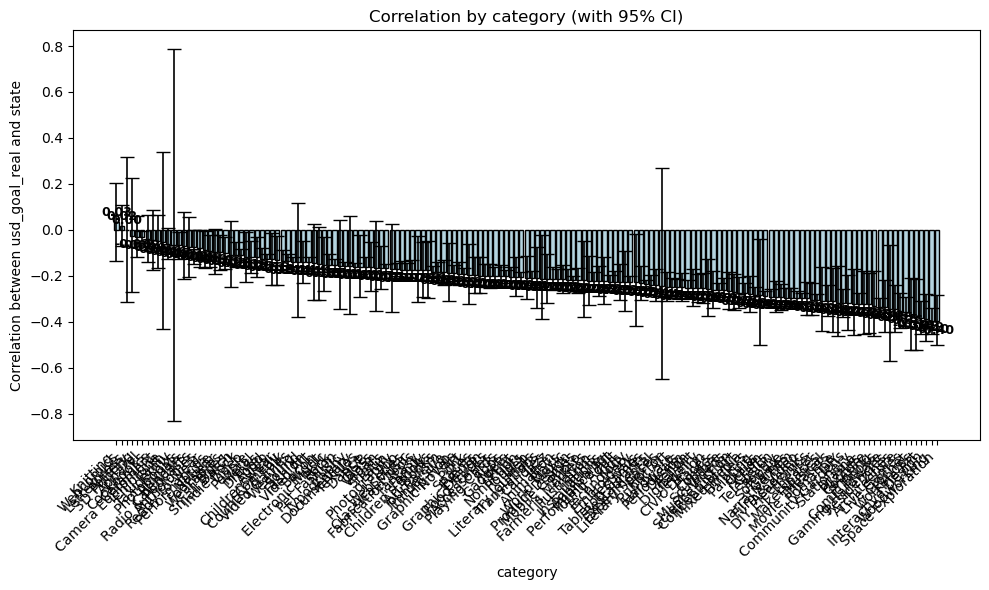

,category,correlation,lower,upper,p_value,n
0,Knitting,0.034982,-0.134772,0.202741,6.870994e-01,135
1,Webcomics,0.018196,-0.071892,0.107990,6.924253e-01,475
2,Letterpress,0.000806,-0.314791,0.316243,9.961152e-01,39
3,Pottery,-0.025255,-0.271322,0.223911,8.442404e-01,63
4,3D Printing,-0.029539,-0.120345,0.061758,5.260654e-01,463
...,...,...,...,...,...,...
154,Workshops,-0.380083,-0.524216,-0.214782,2.011619e-05,119
155,Fine Art,-0.382817,-0.451836,-0.309242,1.042916e-20,552
156,Interactive Design,-0.386397,-0.484344,-0.278883,7.262040e-11,265
157,Woodworking,-0.397338,-0.452683,-0.338944,2.631793e-33,844


In [108]:

def correlation_ci(x, y, alpha=0.05):
    x = np.asarray(x)
    y = np.asarray(y)
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    n = len(x)

    r, p = pointbiserialr(x, y)
    if np.abs(r) == 1 or n < 4:
        return r, np.nan, np.nan, p, n

    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha / 2)
    z_low, z_high = z - z_crit * se, z + z_crit * se
    r_low, r_high = np.tanh([z_low, z_high])

    return r, r_low, r_high, p, n

def plot_grouped_correlations(df, group_col, numeric_col, binary_target, alpha=0.05):
    # Compute correlation by group
    results = []
    for group, gdf in df.groupby(group_col):
        r, low, high, p, n = correlation_ci(gdf[numeric_col], gdf[binary_target], alpha=alpha)
        results.append({
            group_col: group,
            "correlation": r,
            "lower": low,
            "upper": high,
            "p_value": p,
            "n": n
        })
    
    corr_df = pd.DataFrame(results).sort_values("correlation", ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=corr_df,
        x=group_col,
        y="correlation",
        color="lightblue",
        edgecolor="black"
    )

    plt.errorbar(
        x=range(len(corr_df)),
        y=corr_df["correlation"],
        yerr=[
            corr_df["correlation"] - corr_df["lower"],
            corr_df["upper"] - corr_df["correlation"]
        ],
        fmt="none",
        c="black",
        capsize=5,
        linewidth=1.2
    )

    # Annotate bars
    for i, row in corr_df.reset_index().iterrows():
        y = row["correlation"]
        label = f"{y:.2f}"
        va = "bottom" if y >= 0 else "top"
        offset = 0.01 if y >= 0 else -0.01
        ax.text(i, y + offset, label, ha="center", va=va, fontsize=9, fontweight="bold")

    plt.xticks(rotation=45, ha="right")
    plt.ylabel(f"Correlation between {numeric_col} and {binary_target}")
    plt.xlabel(group_col)
    plt.title(f"Correlation by {group_col} (with 95% CI)")
    plt.tight_layout()
    plt.show()

    return corr_df.reset_index(drop=True)

plot_grouped_correlations(
    df=X_explore,
    group_col="category",
    numeric_col="usd_goal_real",
    binary_target="state"
)

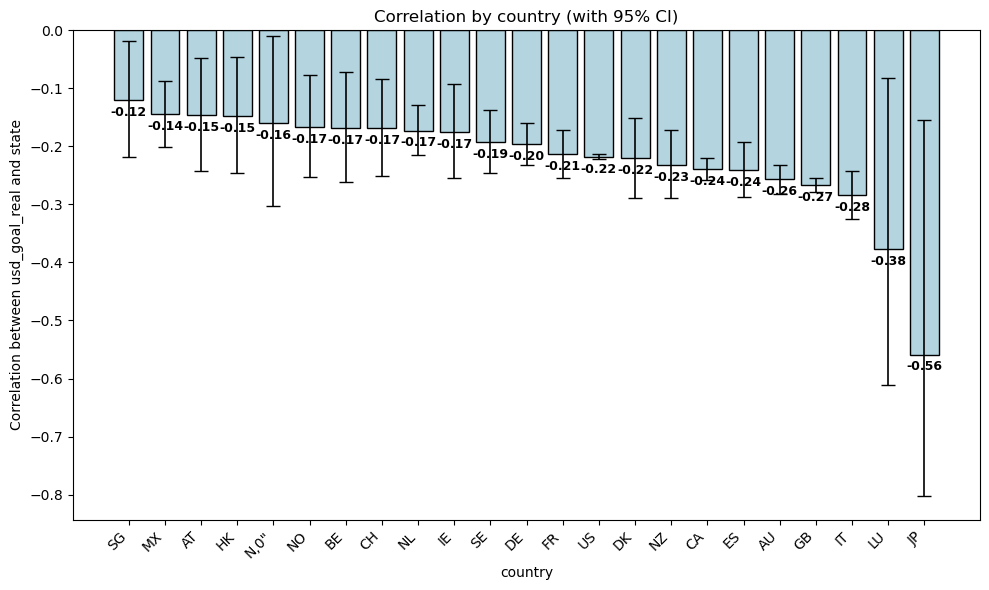

,country,correlation,lower,upper,p_value,n
0,SG,-0.119687,-0.219102,-0.017813,2.147183e-02,369
1,MX,-0.144986,-0.201253,-0.087765,8.455717e-07,1144
2,AT,-0.146413,-0.242315,-0.047677,3.803359e-03,389
3,HK,-0.147148,-0.245420,-0.045882,4.563634e-03,370
4,"N,0""",-0.160158,-0.302949,-0.010334,3.639295e-02,171
5,NO,-0.166526,-0.253527,-0.076852,3.057476e-04,466
6,BE,-0.168265,-0.261879,-0.071514,7.166389e-04,401
7,CH,-0.168553,-0.250515,-0.084192,1.041884e-04,525
8,NL,-0.172886,-0.215643,-0.129468,1.547207e-14,1948
9,IE,-0.174782,-0.255101,-0.092069,4.152873e-05,544


In [109]:
plot_grouped_correlations(
    df=X_explore,
    group_col="country",
    numeric_col="usd_goal_real",
    binary_target="state"
)

Assuming we will want to 
* Rely on main_category * goal
* Rely on a more pruned "category" * goal
* Rely on country * goal

There is more we could do here! But Move forward for now. 

### Final Categorical Steps

This is the magic step!

Here, we iterate on our variable transformations and preprocessing. We have a good start but can do more

1. Imputation. How are we going to do this?
2. Scaling. Yes, I consider this + transformation part of the same step, but we need to scale our variables for ML work.
3. Encoding our categorical features. Are we doing one-hot for everything? Do we need to make decisions about high-cardinality variables? 

Some of those calls we already have thoughts about, but still good to think in more detail. Then, the real magic one:

4. Feature engineering. We go create new columns.

   Common feature engineering patterns to consider:

   * **Duration variables** — e.g., `deadline - launched`
   * **Time-based features** — e.g., `launch_month`, `launch_weekday`, `is_weekend`, `is_holiday`
   * **Log transforms** — e.g., `log1p(backers)`, `log1p(goal)` for skewed numeric fields
   * **Interaction terms** — e.g., `goal * duration`, `backers / duration`, `goal / backers`
   * **Binary flags** — e.g., `has_video`, `has_long_description`, `was_launched_at_night`
   * **Binned features** — e.g., bucketing `goal` into quartiles or predefined thresholds
   * **Text-based signals** — e.g., `title_length`, `num_exclamations`, `contains_urgent_words`
   * **Ratios** — e.g., `pledged / goal`, `backers / goal`, `backers / duration`
   * **High-cardinality encodings** (planned for later) — e.g., top-N categories, target encoding, or frequency encoding



* Categories I will approach as follows (custom transformer):
    - Group into top N (say, 15–20) by frequency (based on X_train only).
    - Replace all others with "Other".
    - One-hot encode the result.
* Feature engineering -- should test for these but COME BACK LATER
    - is_weekend
    - is_holiday
    - title_length
    - num_exclamations (more there? sentiment? NLP? Embeddings?)

In [130]:
def pre_cleaning(df):
    df = df.copy()
    
    # 1. Duplicate handling
    df.drop_duplicates(inplace=True)
    df.drop_duplicates(subset=["ID"], keep = "first", inplace=True)

    # 2. Out of scope
    df = (
        df
        .loc[
            ~df["name"].str.contains("Canceled", case=False, na=False)
        ]
    )

    # only look at clearly successful or failed projects
    df = (
        df
        .loc[
            df["state"].isin(["successful", "failed"])
        ]
    )

    # 3. Missing on key vars
    df.dropna(subset=["name", "ID", "launched", "deadline"], inplace=True)

    return df

# Clean data
df_clean = pre_cleaning(df)

# Split data
X = df_clean.drop(columns=["state"])
y = df_clean["state"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.20, random_state=42)

# Clean y variable to be numeric
def clean_y(input: pd.Series) -> pd.Series:
    """Converts y variable values to binary 1/0 for prediction"""
    return (
        input
        .replace({"failed": 0, "successful": 1})
        .astype("int")
    )
y_train = clean_y(y_train)
y_test = clean_y(y_test)

# Custom Pipeline Classes for Rest of Cleaning
class Cleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.drop_columns = ["goal", "usd_pledged_real", "pledged", "backers", "usd pledged"]
        self.date_columns = ["launched", "deadline"]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        # 4. Drop columns
        X.drop(columns = self.drop_columns, inplace=True)

        # 5. type conversions
        for col_ in self.date_columns:
            X[col_] = pd.to_datetime(X[col_], errors = "coerce")

        # 6. invalid data
        # index rows with mask, columns with list of names --- assign to the pandas "not a time" type
        invalid_dates = X["deadline"] < X["launched"]
        X.loc[invalid_dates, ["deadline", "launched"]] = pd.NaT

        X["usd_goal_real"] = (
            X["usd_goal_real"]
            .mask(
                X["usd_goal_real"] < 0 #default behavior is to replace true values with np.nan
            )
        )

        return X
    
class FeatureEng(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X=X.copy()
        
        #flag duplicate names
        X["is_dup_name"] = (
            X["name"]
            .duplicated(keep=False) #must set to false to flag all duplicates
        )

        #transform goal to a log version
        X["usd_goal_real"] = np.log1p(X["usd_goal_real"])

        # Duration in days (NaT-safe subtraction)
        X["duration"] = (X["deadline"] - X["launched"]).dt.days

        # Day of week (0 = Monday, 6 = Sunday)
        X["launched_dow"] = X["launched"].dt.dayofweek
        X["deadline_dow"] = X["deadline"].dt.dayofweek

        # Weekend flags - make 0/1
        X["launched_is_weekend"] = X["launched_dow"].isin([5, 6]).astype(int)
        X["deadline_is_weekend"] = X["deadline_dow"].isin([5, 6]).astype(int)

        # other
        X["launch_hour"] = X["launched"].dt.hour
        X["launch_month"] = X["launched"].dt.month

        # name length
        X["name_length"] = X["name"].str.len()

        return X
    

class TopN(BaseEstimator, TransformerMixin):
    def __init__(self, columns = None, top_n = 15):
        self.columns = columns
        self.top_n = top_n

    def fit(self, X, y=None):
        self.top_categories_ = { } #will hold them later. Naming convention to end with _ for "learned from data"
        # ^^^ will hold column name : values

        for col in self.columns:
            #returns labels (text) for the top n categories
            top = X[col].value_counts().nlargest(self.top_n).index
            #populate top_categories with set of unique values from top via column name : values
            self.top_categories_[col] = set(top)
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            # get top categories for tha tcolumn
            top = self.top_categories_[col]
            X[col] = X[col].where(
                X[col].isin(top),
                "other"
                ) #retain current value if true, else replace with 'other'
        return X




# Make Pipeline -- No Model Yet

numeric_cols = ['usd_goal_real', 'is_dup_name', 'duration', 'launched_dow', 'deadline_dow', 
                'launched_is_weekend', 'deadline_is_weekend', "launch_hour", "launch_month", "name_length"]
cat_cols = ['category', 'main_category', 'currency', 'country']
date_cols = ['deadline', 'launched']

pipeline = Pipeline(steps = [
    ("clean", Cleaning()),
    ("fe", FeatureEng()),
    ("topn", TopN(columns=["category", "currency", "country"], top_n=15)),
    ("preproc", ColumnTransformer(
        transformers=[
            ("imp", SimpleImputer(strategy = "median"), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
        ],
        #remainder="passthrough" #ensures that other columns aren't dropped
    ))

])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

#### X and Y FULL ###

X_full = pd.concat([
    pd.DataFrame(X_train),
    pd.DataFrame(y_train)
], axis=0).reset_index(drop=True)

y_full = pd.concat([y_train, y_test], axis=0)

#### BUILD X_EXPLORE ####
# those will be arrays--make a df version
# go to last named step
preproc = pipeline.named_steps["preproc"]
feature_names = preproc.get_feature_names_out()
feature_names = [name.replace("remainder__", "") for name in feature_names]
feature_names = [name.replace("imp__", "") for name in feature_names]
X_explore = pd.DataFrame(X_train, columns=feature_names)

#add y_train back in, but pass to numpy first to avoid index alignment
X_explore = pd.concat([
    X_explore, 
    pd.Series(y_train.to_numpy(), name="state")
    ], axis=1)

for col_ in ["usd_goal_real", "duration"]:
    X_explore[col_] = X_explore[col_].astype(float)

for col_ in ["launched_dow", "deadline_dow", "is_dup_name", "launched_is_weekend", "deadline_is_weekend"]:
    X_explore[col_] = X_explore[col_].astype(int)

/var/folders/bj/45wmvwcj3njb1xt57ps1k86r0000gn/T/ipykernel_8540/344322239.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"failed": 0, "successful": 1})
/var/folders/bj/45wmvwcj3njb1xt57ps1k86r0000gn/T/ipykernel_8540/344322239.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"failed": 0, "successful": 1})


We should feature engineer but for now let's do a prelim model

### 3 Preliminary model

In [131]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Train basic XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]


/Users/thomascarpenter/anaconda3/envs/datascibase/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [02:10:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_1f7p_2xalw/croot/xgboost-split_1748329885494/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [132]:
print("📊 XGBoost Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.3f}")
print(f"AUC:       {roc_auc_score(y_test, y_proba):.3f}")


📊 XGBoost Performance:
Accuracy:  0.686
Precision: 0.632
Recall:    0.532
F1 Score:  0.578
AUC:       0.743


# Phase 2. ML Flow and Iteration

##### CHAT GPT THOUGHTS ON NEXT STEPS

Great question — when you're at the **feature engineering** phase, a good approach is to draw from proven "feature engineering templates" or **common patterns** based on data types, domain knowledge, and transformations that typically improve model performance.

Here’s a structured list of **feature engineering templates**, categorized by type:

---

## 🕒 Date/Time Features

For columns like `launched` or `deadline`:

```python
df["duration_days"] = (df["deadline"] - df["launched"]).dt.days
df["launch_dayofweek"] = df["launched"].dt.dayofweek  # 0=Monday
df["launch_hour"] = df["launched"].dt.hour
df["launch_month"] = df["launched"].dt.month
df["launched_weekend"] = df["launch_dayofweek"] >= 5
```

> 🚀 Useful for seasonal patterns, weekend effects, or campaign timing strategies.

---

## 💰 Numeric Transformations

Apply if your numeric variables are skewed or need normalization:

```python
df["log_goal"] = np.log1p(df["usd_goal_real"])
df["backers_per_dollar"] = df["backers"] / (df["usd_goal_real"] + 1)
```

> 🧮 Use `log1p` for count-like features and ratios to scale better.

---

## 🏷️ Categorical Enhancements

### 1. **Frequency Encoding**

```python
category_counts = df["main_category"].value_counts()
df["main_category_freq"] = df["main_category"].map(category_counts)
```

> Helps when high-cardinality categorical variables have different impact based on frequency.

### 2. **Target Mean Encoding (careful — use CV folds)**

```python
category_target_means = df.groupby("main_category")["target"].mean()
df["main_category_target_enc"] = df["main_category"].map(category_target_means)
```

> ⚠️ Risk of target leakage — only use inside cross-validation pipelines or for downstream models.

---

## 📊 Text Features (if you want to explore later)

For project names or descriptions:

```python
df["name_length"] = df["name"].str.len()
df["name_word_count"] = df["name"].str.split().str.len()
df["name_has_kickstarter"] = df["name"].str.contains("kickstarter", case=False, na=False)
```

> 📘 Simple NLP can still be useful before you jump to full embeddings or TF-IDF.

---

## 🧠 Interaction Features

Create new features by combining others:

```python
df["goal_times_duration"] = df["usd_goal_real"] * df["duration_days"]
df["pledged_ratio"] = df["usd_pledged_real"] / (df["usd_goal_real"] + 1)
```

> Often found via domain intuition or feature importance analysis.

---

## 🔁 Binning and Grouping

Use for non-linear relationships or noise reduction:

```python
df["goal_bin"] = pd.qcut(df["usd_goal_real"], q=5, labels=False)
```

> Especially helpful for models that don’t model nonlinearity well (e.g., logistic regression).

---

## 🧼 Feature Engineering Template Summary

| Type         | Common Features                              |
| ------------ | -------------------------------------------- |
| Datetime     | `duration_days`, `launch_dayofweek`, `month` |
| Numeric      | `log(goal)`, `ratios`, `backers_per_dollar`  |
| Categorical  | frequency encoding, target mean encoding     |
| Text         | length, keyword flags, word count            |
| Interactions | `goal * duration`, `pledged / goal`          |
| Binning      | `qcut` on skewed numeric features            |

---

Would you like help building a **feature engineering transformer** that adds some of these automatically? Or want examples for the Kickstarter dataset specifically?
